## Generate multiple GFP localization patterns for a given cell

## Load libraries

In [2]:
import json
from pathlib import Path
import os

from tqdm import tqdm

import pandas as pd
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

import integrated_cell
from integrated_cell import model_utils, utils
from integrated_cell.utils.plots import tensor2im, imshow

## Prep

### Gpus

In [3]:
gpu_ids = [7]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()

### Load models

In [4]:
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_94544'    

networks, dp_ref, args_ref = utils.load_network_from_dir(model_dir, parent_dir, suffix=suffix)

ref_enc = networks['enc']
ref_dec = networks['dec']

parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
suffix = '_93300'

networks, dp_target, args_target = utils.load_network_from_dir(model_dir, parent_dir, suffix=suffix)
    
target_enc = networks['enc']
target_dec = networks['dec']

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth


### Set results dir

In [5]:
RESULTS_DIR = '/allen/aics/modeling/rorydm/results/multiscale_structure_similarity/generated_gfp_images/'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
print("Results dir: {}".format(RESULTS_DIR))

save_dir = RESULTS_DIR

Results dir: /allen/aics/modeling/rorydm/results/multiscale_structure_similarity/generated_gfp_images/


### Helper function for saving images

In [6]:
from aicsimageio.writers import OmeTiffWriter

def im_write(im, path):
    im = im.cpu().detach().numpy().transpose(3,0,1,2)
    
    with OmeTiffWriter(path, overwrite_file=True) as writer:
        writer.save(im)

### Set up the autoencoder

In [7]:
from integrated_cell.networks.ref_target_autoencoder import Autoencoder

mode = 'test'
dp = dp_target
u_classes, class_inds = np.unique(dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode), return_inverse=True)
u_class_names = dp.label_names[u_classes]

ae = Autoencoder(ref_enc, ref_dec, target_enc, target_dec)
ae.train(False)
ae = ae.cuda()

## main settings

In [8]:
N_IMAGES_PER_STRUCTURE = 128

STRUCTURES_TO_GEN = [
    'Desmosomes',
    'Endoplasmic reticulum',
    'Golgi',
    'Microtubules',
    'Mitochondria',
    'Nuclear envelope',
    'Nucleolus (Dense Fibrillar Component)',
    'Nucleolus (Granular Component)',
]

structure_to_gen_ids = [np.where(u_class_names == structure)[0].item() for structure in STRUCTURES_TO_GEN]
structure_to_gen_ids = [torch.tensor([x]) for x in structure_to_gen_ids]

### find the images we need

In [9]:
# pick this based on pca location or whatever
MY_CELL_ID = 10000

# grap metadata
cell_metadata = dp.csv_data[dp.csv_data.CellId == MY_CELL_ID].drop(columns=["level_0", "Unnamed: 0"])

# find dp index from ID
cell_index = cell_metadata.index.item()

# search for which split this id is in
for k,v in dp.data.items():
    if cell_index in v["inds"]:
        split = k

# grab the sampled image
gfp_img, struct_ind, ref_img = dp.get_sample(train_or_test=split, inds=[cell_index])

# make sure struct name matches in dp and csv
assert u_class_names[struct_ind] == cell_metadata.Structure.item()

# make the one-hot encoding
label_onehot = utils.index_to_onehot(struct_ind, len(u_classes)).cuda()

# move ref image to gpu
ref = ref_img.cuda()

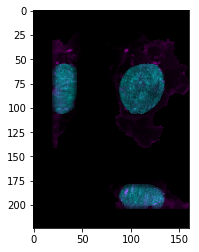

In [10]:
plt.imshow(tensor2im(ref_img));

## loop over structs to generate and save images

In [11]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# TODO: loop over cellid

In [20]:
BATCH_SIZE=16

image_dir = Path(RESULTS_DIR) / "images"
image_dir.mkdir(parents=True, exist_ok=True)

df = pd.DataFrame()

with tqdm(total=N_IMAGES_PER_STRUCTURE*len(STRUCTURES_TO_GEN)) as pbar:
    for structure, struct_ind in zip(STRUCTURES_TO_GEN, structure_to_gen_ids):

        df_tmp = cell_metadata[["CellId"]].copy()
        df_tmp["GeneratedStructureName"] = structure
        df_tmp["GeneratedStructureInstance"] = -1
        df_tmp["GeneratedStructuePath"] = ""
        df_tmp = pd.concat([df_tmp]*N_IMAGES_PER_STRUCTURE).reset_index(drop=True)

        for batch in chunks(range(N_IMAGES_PER_STRUCTURE), BATCH_SIZE):

            # one hot structure labels to generate,same for whole batch
            labels_gen_batch = utils.index_to_onehot(struct_ind, len(u_classes)).repeat(len(batch),1).cuda()

            # repeat reference structure over batch
            ref_batch = ref.repeat([len(batch), 1, 1, 1, 1])

            # generate our gfp samples
            target_gen_batch, _ = ae(target=None, ref=ref_batch, labels=labels_gen_batch)

            # save images
            for b,im_tensor in zip(batch,target_gen_batch):
                struct_safe_name = structure.replace(" ", "_").lower()
                img_path = image_dir / f"generated_gfp_image_struct_{struct_safe_name}_instance_{b}.ome.tiff"
                im_write(im_tensor, img_path)

                df_tmp.at[b, "GeneratedStructureInstance"] = b
                df_tmp.at[b, "GeneratedStructuePath"] = img_path
                
                pbar.update(1)

        df = df.append(df_tmp)

    # merge df with metadata for cell
    df = df.reset_index(drop=True)
    df_out = cell_metadata.merge(df)
    
# save df
df_out.to_csv(Path(RESULTS_DIR) / "generated_structures.csv")

100%|██████████| 1024/1024 [12:25<00:00,  1.37it/s]


In [ ]:
from aicsimageio import AICSImage

sample_row = df_out.sample()
sample_path = sample_row.GeneratedStructuePath.item()
sample_stuct = sample_row.GeneratedStructureName.item()
sample_instance = sample_row.GeneratedStructureInstance.item()

sample_img = AICSImage(sample_path)

print(sample_stuct, sample_instance)
plt.imshow(tensor2im(torch.tensor(sample_img.data[0])));

In [16]:
df_out.shape

(1024, 82)